Spring 2023 ECE500 Project: Practical Bayesian Optimization of Machine Learning Algorithms

Madeleine Yuh (email: myuh@purdue.edu)

Gaussian Process

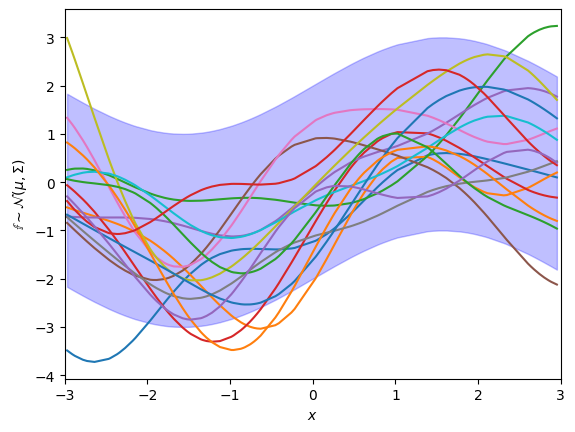

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_data(n):
    np.random.seed(100)
    X = np.random.uniform(-3., 3., (n, 1))
    X.sort(axis=0)
    y = np.sin(X)
    return X, y

def kernel(x1,x2,sigma=1):
    return np.exp(-1/(2*sigma**2)*np.sum(x1-x2)**2)

n = 100
x,mu = generate_data(n)
x = x.reshape(-1,)
mu = mu.reshape(-1,)
seed = np.asarray((range(n)))

k = np.zeros([len(x),len(x)])
for i in range (len(x)):
    for j in range(len(x)):
        k[i,j] = kernel(x[i],x[j])
f = np.zeros([len(x),n])
for i in range(n):
    np.random.seed(seed[i])
    f[:,i] = np.random.multivariate_normal(mu, k)

std = np.sqrt(np.diag(k))

# plotting a graph 
fig1 = plt.figure() 
for i in range(15):
    plt.plot(x,f[:,i]) 
plt.fill_between(x.flat, mu-2*std, mu+2*std, color='blue', alpha=0.25)
plt.xlabel(r'$x$')
plt.ylabel(r'$\mathbb{f} \sim \mathcal{N} (\mu,\Sigma)$')
plt.xlim([-3,3])
plt.show()

Posterior Gaussian Process without noise

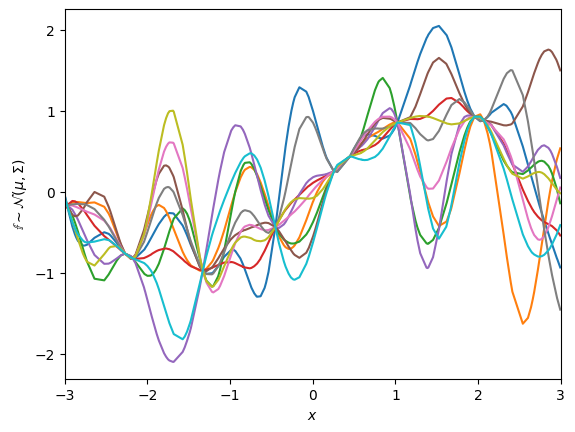

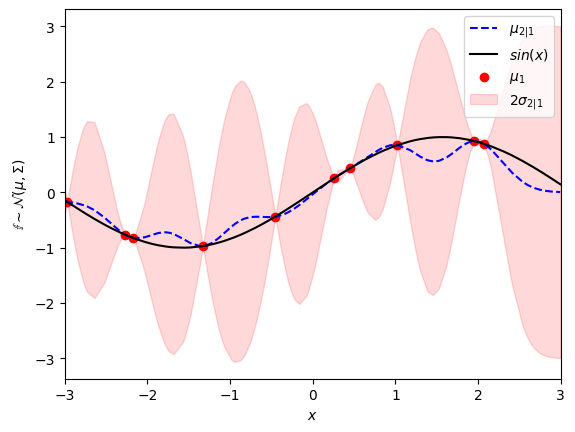

In [2]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n, noise_variance = 1e-6):
    np.random.seed(100)
    X = np.random.uniform(-3., 3., (n, 1))
    X.sort(axis=0)
    y = (np.sin(X) + np.random.randn(n, 1) * noise_variance**0.5)
    return X, y

def kernel(x, y, sigma=1):
    dist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T)
    return np.exp(-1 / (2*sigma)* dist)

def posteriorGP(X, Xtest, sigma, noise_var):
    N = len(X)
    n = len(Xtest)
    K  = kernel(X, X, sigma)
    K_test = kernel(Xtest, Xtest, sigma)
    L  = np.linalg.cholesky(K + noise_var*np.eye(N))
    Lk = np.linalg.solve(L, kernel(X, Xtest, sigma))
    mu = np.dot(Lk.T, np.linalg.solve(L, y)).reshape(-1)
    std = np.sqrt(np.diag(K_test) - np.sum(Lk**2, axis=0))
    return (mu, std)

sigma = 0.1
noise_var = 1e-6
n_samples = 200
x_actual,y_actual = generate_data(n_samples,0)

X, y = generate_data(10,noise_var)
Xtest, ytest = generate_data(n_samples,noise_var)
Xtest.sort(axis=0)

N = len(X) 
n = len(Xtest)
K = kernel(X, X, sigma)
K_test = kernel(Xtest, Xtest,0.1)
L = np.linalg.cholesky(K + noise_var*np.eye(N))
Lk = np.linalg.solve(L, kernel(X, Xtest, sigma))
mu = np.dot(Lk.T, np.linalg.solve(L, y))
L = np.linalg.cholesky(K_test + noise_var*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,n_samples)))

plt.figure()
#10 out of 100 f_post functions
for i in range(10):
    plt.plot(Xtest,f_post[:,i]) 
    plt.xlabel('$x$')
    plt.ylabel(r'$\mathbb{f} \sim \mathcal{N} (\mu,\Sigma)$')
plt.xlim([-3,3])

mu, std = posteriorGP(X, Xtest, sigma, noise_var)
plt.figure()
plt.plot(Xtest,mu, 'b--', label='$\mu_{2|1}$')
plt.plot(x_actual,y_actual, 'k-', label='$sin(x)$')
plt.scatter(X, y, c='r', marker='o', label='$\mu_1$')
plt.fill_between(Xtest.flat, mu-3*std, mu+3*std, color='red', alpha=0.15, label='$2 \sigma_{2|1}$')
plt.xlim([-3,3])
plt.xlabel('$x$')
plt.ylabel(r'$\mathbb{f} \sim \mathcal{N} (\mu,\Sigma)$')
plt.legend(loc="best")
plt.show()


Posterior Gaussian Process with noise

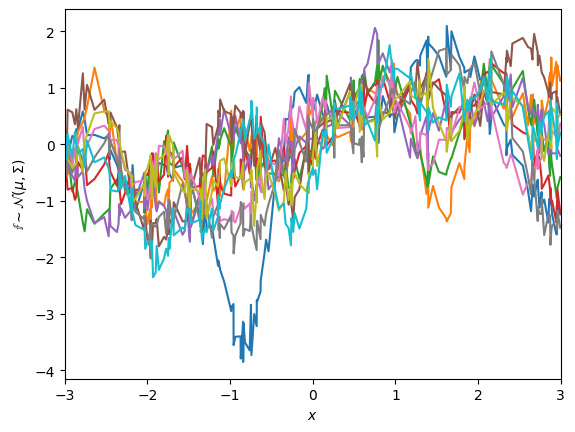

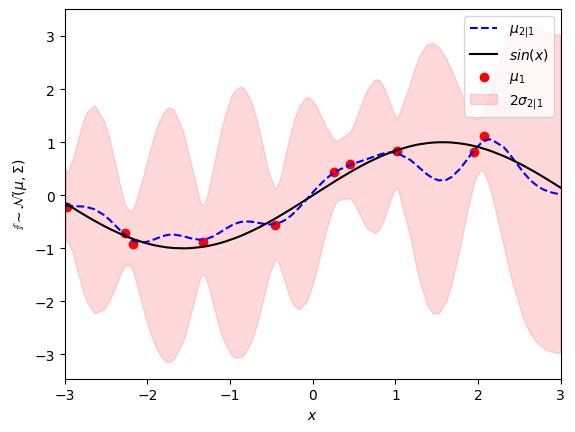

In [3]:
sigma = 0.1
noise_var = 0.05
n_samples = 200
x_actual,y_actual = generate_data(n_samples,0)

X, y = generate_data(10,noise_var)
Xtest, ytest = generate_data(n_samples,noise_var)
Xtest.sort(axis=0)

N = len(X) 
n = len(Xtest)
K = kernel(X, X, sigma)
K_test = kernel(Xtest, Xtest,0.1)
L = np.linalg.cholesky(K + noise_var*np.eye(N))
Lk = np.linalg.solve(L, kernel(X, Xtest, sigma))
mu = np.dot(Lk.T, np.linalg.solve(L, y))
L = np.linalg.cholesky(K_test + noise_var*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,n_samples)))

plt.figure()
for i in range(10):
    plt.plot(Xtest,f_post[:,i]) 
    plt.xlabel('$x$')
    plt.ylabel(r'$\mathbb{f} \sim \mathcal{N} (\mu,\Sigma)$')
plt.xlim([-3,3])

mu, sd = posteriorGP(X, Xtest, sigma, noise_var)
plt.figure()
plt.plot(Xtest,mu, 'b--', label='$\mu_{2|1}$')
plt.plot(x_actual,y_actual, 'k-', label='$sin(x)$')
plt.scatter(X, y, c='r', marker='o', label='$\mu_1$')
plt.fill_between(Xtest.flat, mu-3*sd, mu+3*sd, color='red', alpha=0.15, label='$2 \sigma_{2|1}$')
plt.xlim([-3,3])
plt.xlabel('$x$')
plt.ylabel(r'$\mathbb{f} \sim \mathcal{N} (\mu,\Sigma)$')
plt.legend(loc="best")
plt.show()


Bayesian Optimization of Hyperparameters

In [4]:
%reset -f
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [29]:
class Bayesian_Optimization():
    def __init__(self,objective,x_range,init_points=10, initialplot=False): # replace Gaussian with Matern52 later
        
        self.x_min = np.array(x_range[0]).reshape(-1)
        self.x_max = np.array(x_range[1]).reshape(-1)
        self.x_mid = (self.x_min+self.x_max)*0.5
        self.x_range = np.linalg.norm(self.x_min-self.x_max)
        self.dim = self.x_min.size
        self.x = np.vstack((self.x_min, np.random.uniform(self.x_min, self.x_max, (init_points-2, 1)),  self.x_max))
        self.x.sort(axis=0)
        self.objective = objective

        print(self.x)
        self.y = np.array([objective(t) for t in self.x]).reshape(-1,1)
        self.prior = {'v': 1,'t0': 1,'t': 1,'a': 1,"b": 1,"a0": 1,"b0": 1}

        X_actual = np.linspace(self.x_min,self.x_max,20).reshape(-1,1)
        y_actual = self.objective(X_actual).reshape(-1,1)

        if initialplot == True:
            plt.figure(figsize=(6,3))
            plt.xlim(self.x_min,self.x_max)
            plt.plot(X_actual,y_actual,'k--',label='actual function')
            plt.scatter(self.x, self.y, marker='o', c = 'b',label='existing datapoints')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(loc="best")
            plt.show()

    def next_x(self,params,acquisition,gp):
        def acq(x_opt):
            x_opt = np.array(x_opt).reshape(-1,1)
            m,v = gp.predict(x_opt,point=params,diag=True,pred_noise=False)
            m = m[0]
            std = np.sqrt(v[0])
            f_best = self.y.min()
            gamma = (-f_best+m)/std
            if acquisition == "EI":
                return std*(norm.cdf(gamma)*gamma+norm.pdf(gamma))
            elif acquisition == "PI":
                return norm.cdf(gamma)
            elif acquisition == "LCB":
                return m-2*std
                
        # optimize
        bounds = [(l,h) for l,h in zip(self.x_min, self.x_max)]
        result = minimize(acq,x0=self.x_mid,bounds=bounds)
        x_testval = np.array(np.linspace(-3,3,20)).reshape(-1,1)
        m,v = gp.predict(x_testval,point=params,diag=True,pred_noise=False)
        std = np.sqrt(v)
        x_next = result.x
        print("grad:",result.jac)
        print("next x:",x_next)

        X_actual = np.linspace(self.x_min,self.x_max,20)
        y_actual = self.objective(X_actual)
        plt.figure(figsize=(6,3))
        plt.fill_between(x_testval.flatten(), m-2*std, m+2*std, color="r", alpha=0.5)
        plt.plot(X_actual,y_actual,'k--',label="actual function")
        plt.scatter(self.x, self.y, marker='o', s=20, c='b',label='existing datapoints')
        plt.scatter([x_next], [self.objective(x_next)], marker='o', s=30, c='r',label="next one")
        plt.legend(loc="best")
        plt.xlim(self.x_min,self.x_max)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        return x_next

    def Iteration(self,x_prev = None, y_prev = None, mode = "MCMC", acquisition = "PI",max_iter = 10):
        if x_prev != None and y_prev != None:
            self.x = x_prev
            self.y = y_prev
        for i in range(max_iter):
            self.x = self.x.reshape(-1,1)
            self.y = self.y.reshape(-1,1).flatten()
            with pm.Model() as model:
                theta = pm.Gamma("t",alpha=self.prior['a'],beta=self.prior['b'],shape = (self.dim,))
                theta0 = pm.Gamma("t0",alpha=self.prior['a0'],beta=self.prior['b0']) 
                K = theta0**2 * pm.gp.cov.Matern52(input_dim = self.dim,ls = theta)
                m = pm.gp.mean.Constant(self.y.mean())
                gp = pm.gp.Marginal(m,K)
                nu = pm.HalfCauchy("nu",self.prior['v'])
                gp.marginal_likelihood("f", X=self.x, y=self.y, noise=nu)

                if mode == "MAP":
                    MAP = pm.find_MAP()
                    x_temp = self.next_x(params=MAP,acquisition=acquisition,gp=gp)
                elif mode == "MCMC":
                    trace = pm.sample(1000,chains=1)
                    pm.traceplot(trace)
                    x_temp_ls = []
                    for t in trace[::250]:
                        x_temp_ls.append(self.next_x(params=t,acquisition=acquisition,gp=gp))
                    x_temp = np.array(x_temp_ls).mean(axis=0)
                
            if x_temp in self.x:
                break

            y_temp = self.objective(x_temp)
            self.x = np.vstack((self.x,x_temp))
            self.y = np.hstack((self.y,y_temp))
            best_x = self.x[np.argmin(self.y)]
        return best_x,self.x, self.y


objective = lambda x: x**2 + np.sin(x)
x_range = [-3,3]
maximum_iteration = 15
init_points = 15

MAP, Acquisition Function: Probability Improvement


[[-3.        ]
 [-2.14984742]
 [-1.95638686]
 [-1.0303762 ]
 [-0.82231842]
 [ 1.15358801]
 [ 1.25169784]
 [ 1.50355981]
 [ 1.6253752 ]
 [ 1.64051193]
 [ 1.67854719]
 [ 1.76862225]
 [ 1.84609983]
 [ 2.2514304 ]
 [ 3.        ]]


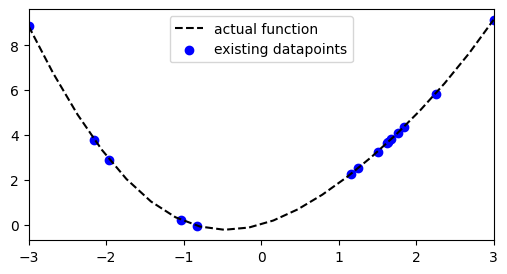


grad: [1.42309201e-21]
next x: [-0.78813971]


<Figure size 640x480 with 0 Axes>

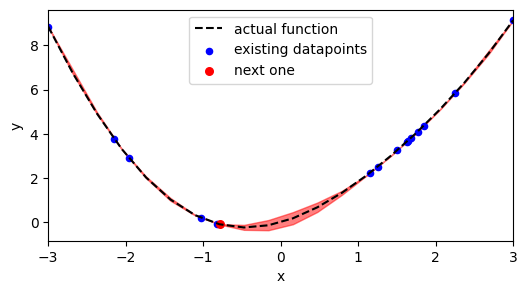


grad: [1.74466312e-06]
next x: [-0.52801377]


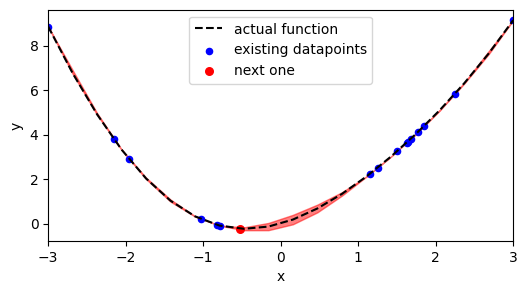


grad: [0.04226064]
next x: [-0.49958115]


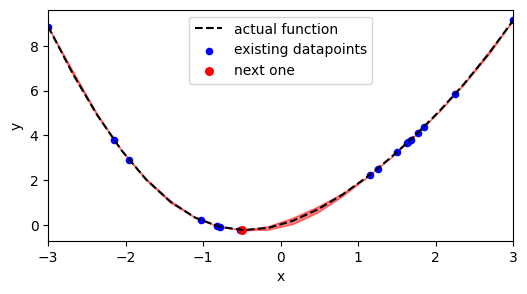


grad: [0.]
next x: [0.]


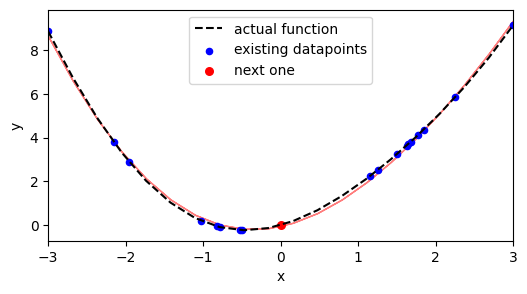


grad: [0.]
next x: [0.]


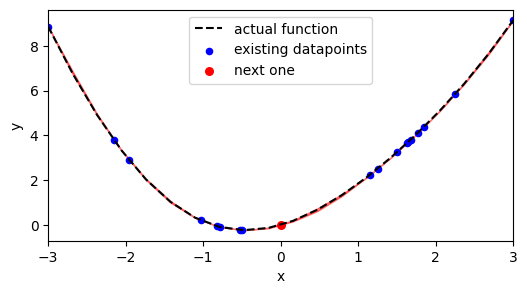

best x:  [-0.49958115]


In [6]:
#Initialize
PI_MAP= Bayesian_Optimization(objective=objective, x_range = x_range, init_points=init_points, initialplot=True)
#Optimize
PI_MAP_best,PI_MAP_x, PI_MAP_y = PI_MAP.Iteration(mode = "MAP",acquisition = "PI", max_iter = maximum_iteration)
print("best x: ",PI_MAP_best)

MAP, Acquisition Function: Expectation Improvement

[[-3.        ]
 [-2.65572012]
 [-1.75353766]
 [-1.21722417]
 [-0.8472239 ]
 [ 1.43276922]
 [ 1.65443695]
 [ 1.85636673]
 [ 1.96811208]
 [ 2.46711684]
 [ 2.64832415]
 [ 2.75916872]
 [ 2.83708155]
 [ 2.9940828 ]
 [ 3.        ]]


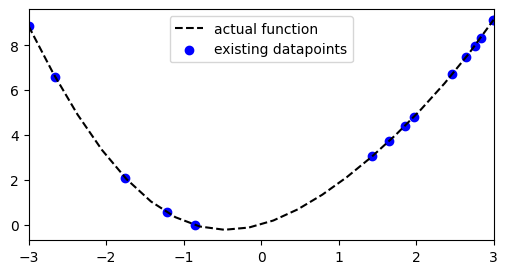


grad: [9.5386325e-06]
next x: [-0.47335458]


<Figure size 640x480 with 0 Axes>

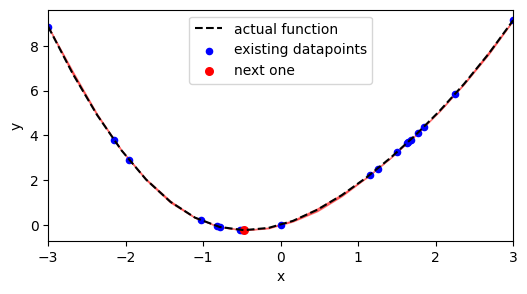


grad: [-23.12821064]
next x: [7.46736891e-07]


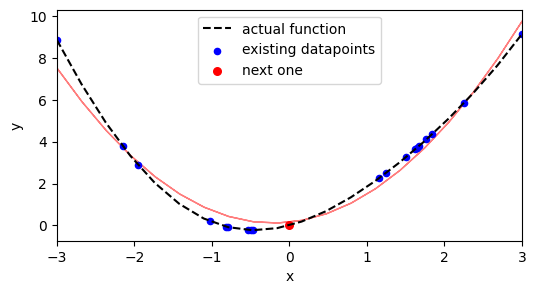


grad: [54.86712181]
next x: [-0.40087214]


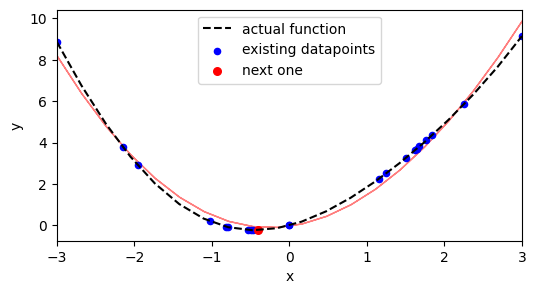


grad: [1.38228672]
next x: [-0.66983935]


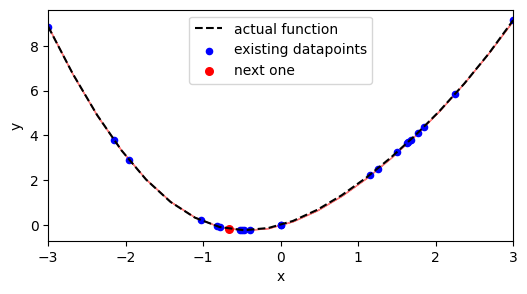


grad: [3.28524595e-05]
next x: [-0.45206767]


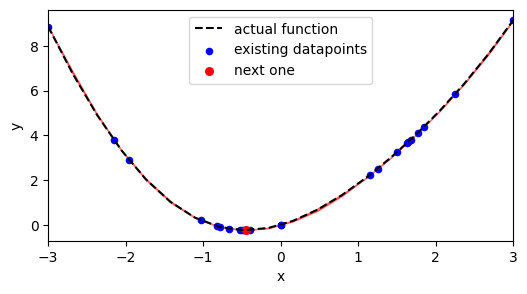


grad: [-0.00012478]
next x: [-0.45103773]


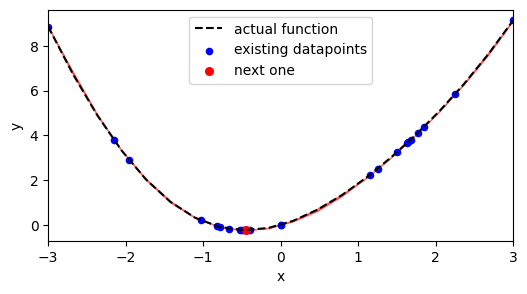


grad: [0.1390315]
next x: [-0.45660309]


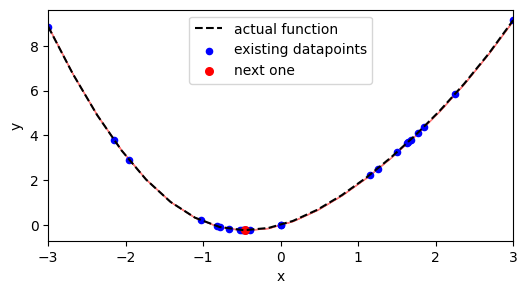


grad: [2.67353893]
next x: [-0.51433824]


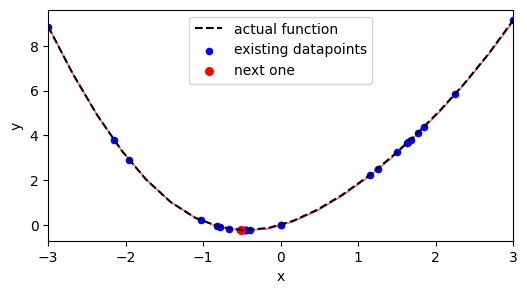


grad: [0.086754]
next x: [-0.48543061]


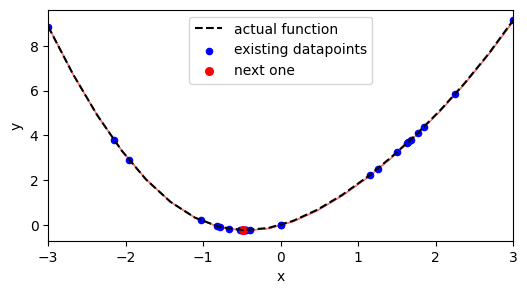


grad: [30.16317136]
next x: [-0.65846368]


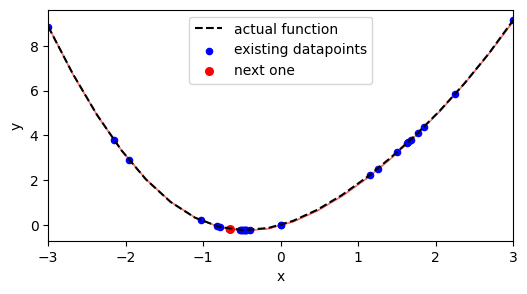


grad: [1269.94058363]
next x: [6.19329092e-07]


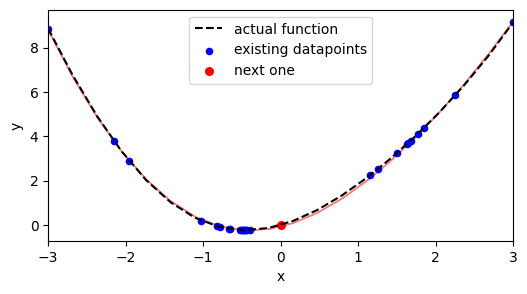


grad: [-16884.58698257]
next x: [-2.57722109e-07]


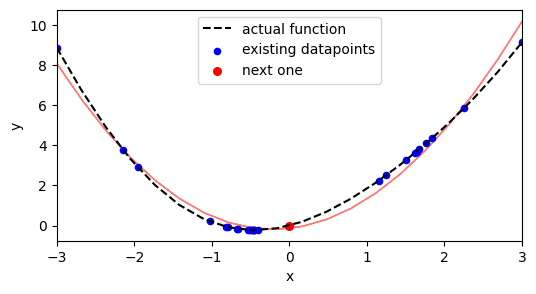


grad: [2797580.40691461]
next x: [1.5520369e-06]


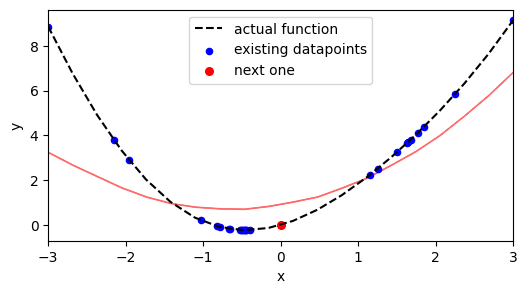


grad: [3969.7098158]
next x: [0.]


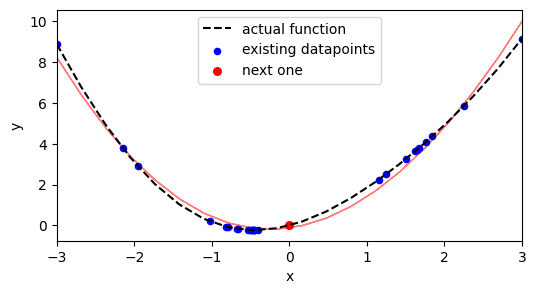

best x:  [-0.45103773]


In [7]:
#Initialize
EI_MAP= Bayesian_Optimization(objective=objective, x_range = x_range, init_points=init_points, initialplot=True)
#Optimize
EI_MAP_best,EI_MAP_x, EI_MAP_y = PI_MAP.Iteration(mode = "MAP",acquisition = "EI", max_iter = maximum_iteration)
print("best x: ",EI_MAP_best)

MAP, Acquisition Function: Lower Confidence Bound

[[-3.        ]
 [-2.89452939]
 [-2.67866596]
 [-2.48748249]
 [-2.34286743]
 [-2.13766552]
 [-1.39503281]
 [-0.78431469]
 [-0.70039941]
 [-0.27213662]
 [ 1.6447273 ]
 [ 1.83020566]
 [ 2.55826015]
 [ 2.84351198]
 [ 3.        ]]


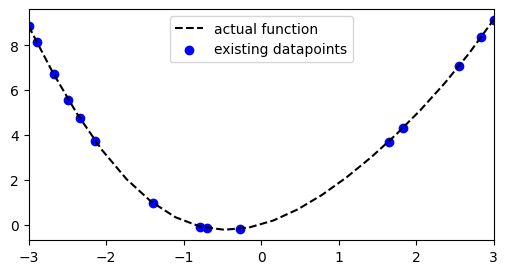


grad: [1530.08187382]
next x: [-8.32845853e-08]


<Figure size 640x480 with 0 Axes>

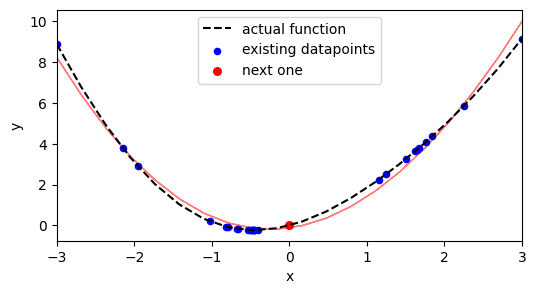


grad: [4165.67540309]
next x: [-1.78356611e-06]


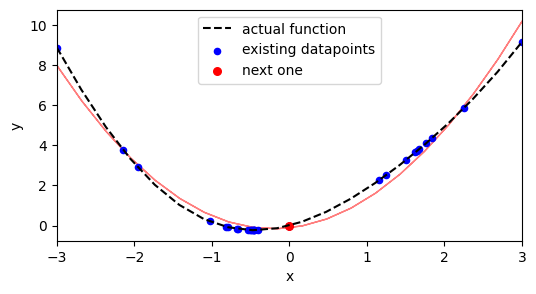


grad: [1083.30696359]
next x: [-3.80332839e-06]


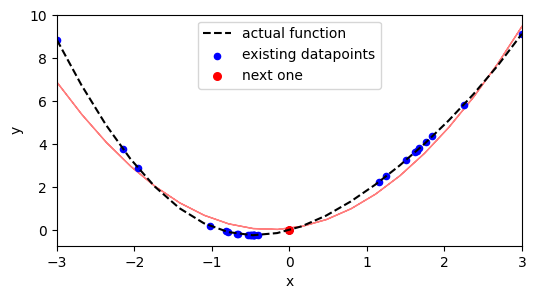


grad: [292415.94400897]
next x: [1.11860313e-07]


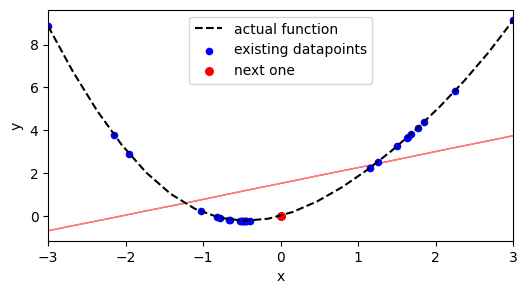


grad: [0.00181648]
next x: [-0.92139031]


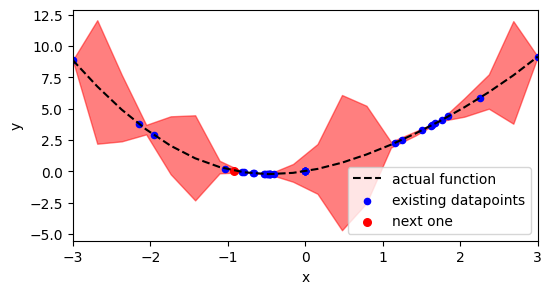


grad: [11.45480342]
next x: [-0.44897491]


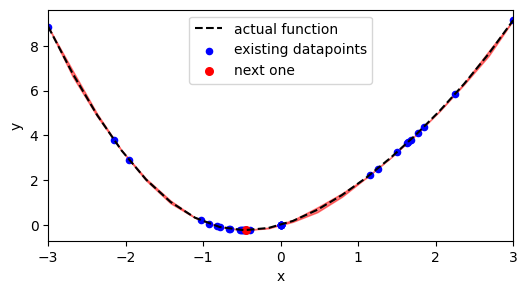


grad: [2419.04991879]
next x: [-1.78328139e-06]


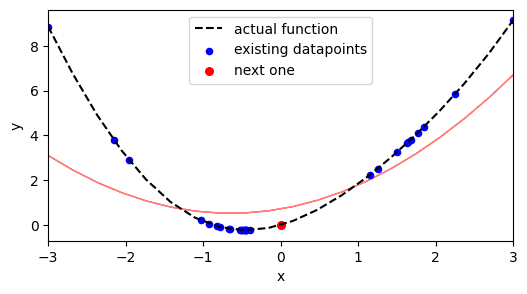


grad: [12374.87883885]
next x: [-1.26835416e-06]


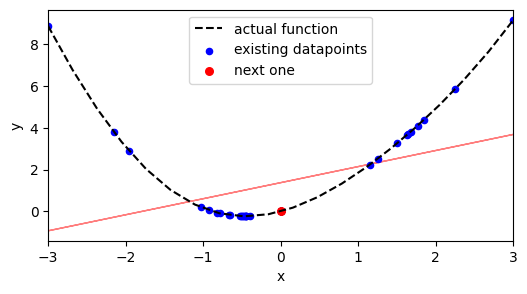


grad: [-943.24355213]
next x: [7.6777598e-07]


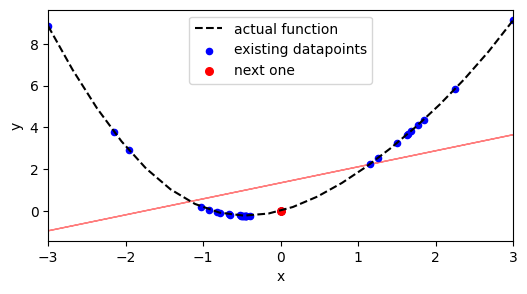


grad: [-0.0173072]
next x: [-0.45678304]


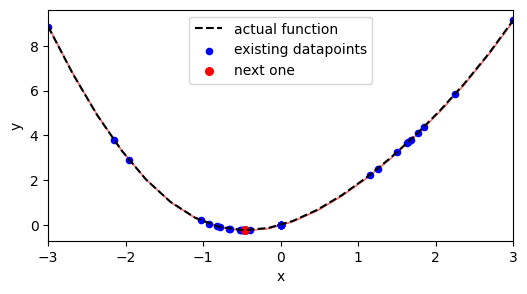


grad: [-0.01119399]
next x: [-0.44236536]


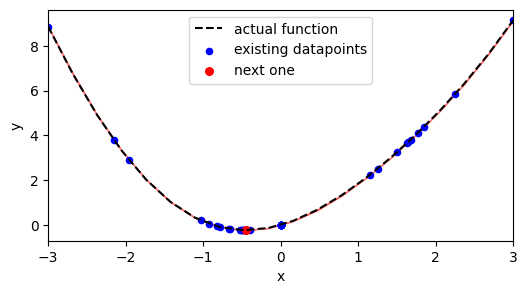


grad: [0.25906069]
next x: [-0.46513639]


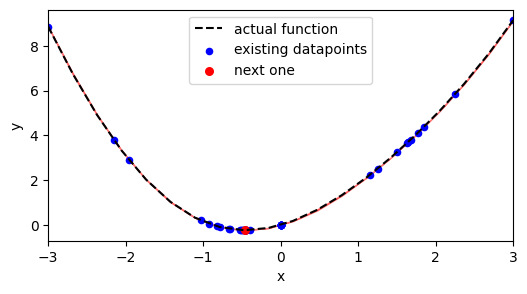


grad: [6.8217622]
next x: [-0.72363204]


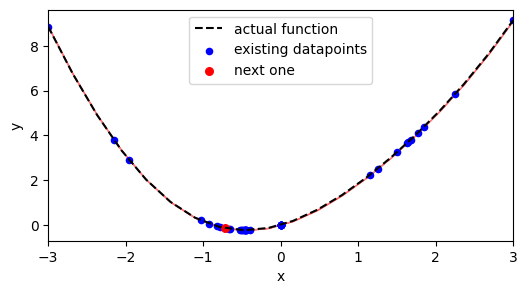


grad: [0.0186273]
next x: [-0.44802108]


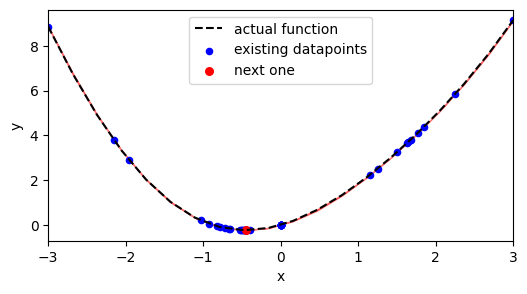


grad: [0.56044646]
next x: [-0.4499071]


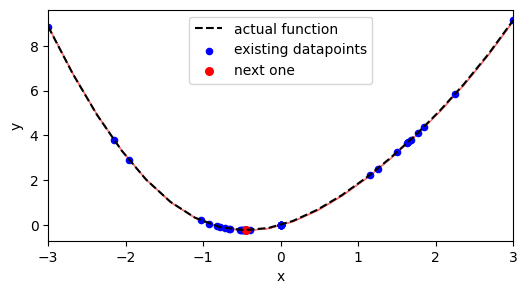

best x:  [-0.4499071]


In [8]:
#Initialize
LCB_MAP= Bayesian_Optimization(objective=objective, x_range = x_range, init_points=init_points, initialplot=True)
#Optimize
LCB_MAP_best,LCB_MAP_x, LCB_MAP_y = PI_MAP.Iteration(mode = "MAP",acquisition = "LCB", max_iter = maximum_iteration)
print("best x: ",LCB_MAP_best)

MCMC, Acquisition Function: Probability Improvement

[[-3.        ]
 [-2.85430854]
 [-2.43724252]
 [-0.22073029]
 [ 0.31379475]
 [ 0.64473169]
 [ 0.90988007]
 [ 1.24762866]
 [ 1.41036401]
 [ 1.50614344]
 [ 1.62284276]
 [ 1.71806166]
 [ 2.06010513]
 [ 2.20981023]
 [ 3.        ]]


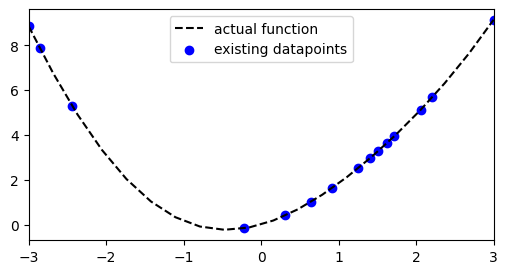

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [0.00084696]
next x: [-0.23343401]


<Figure size 640x480 with 0 Axes>

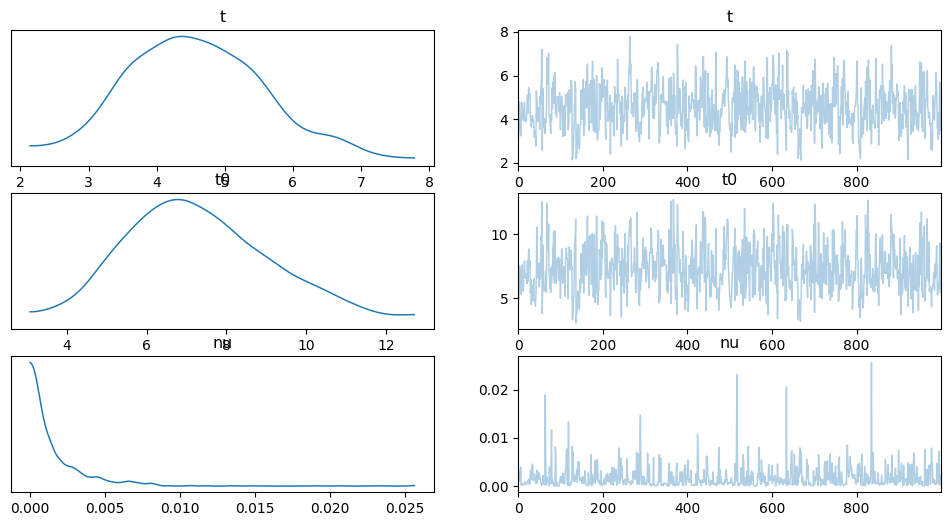

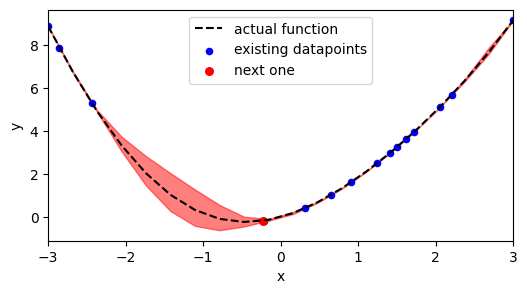

grad: [0.]
next x: [0.]


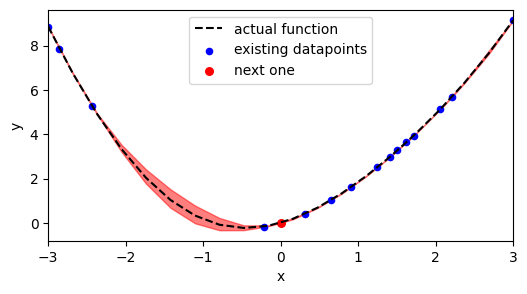

grad: [0.]
next x: [0.]


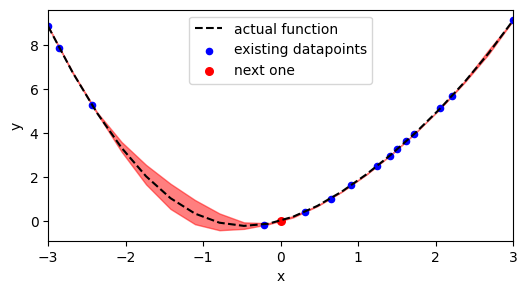

grad: [0.]
next x: [0.]


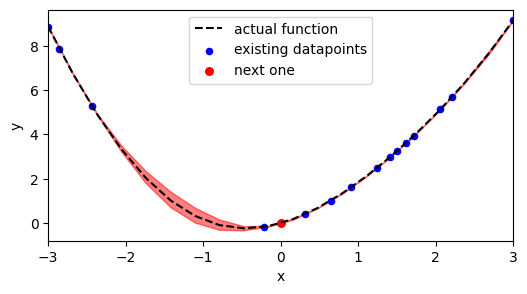

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, t0, t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 35 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [0.]
next x: [0.]


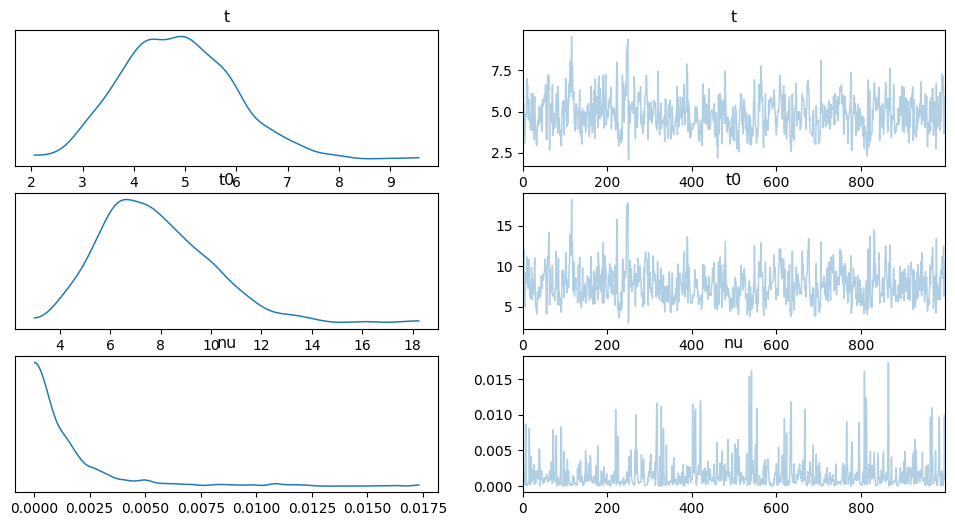

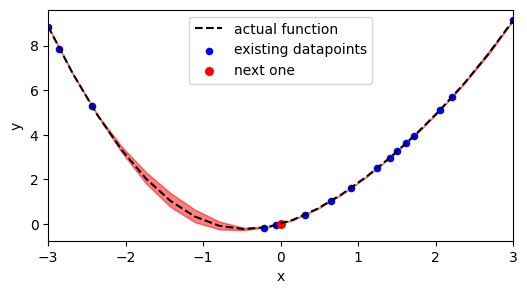

grad: [0.]
next x: [0.]


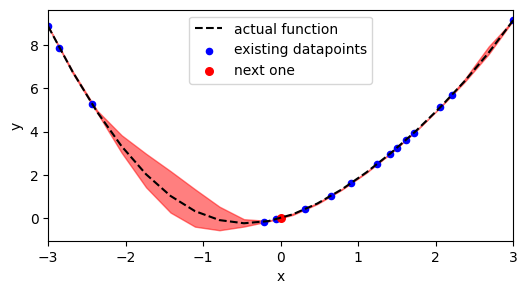

grad: [0.]
next x: [0.]


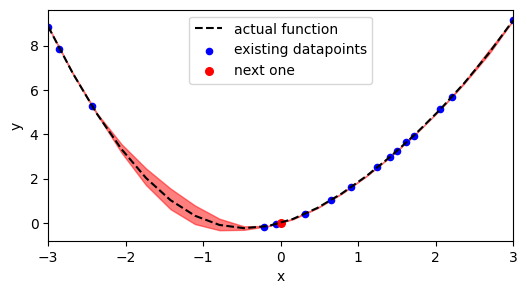

grad: [0.]
next x: [0.]


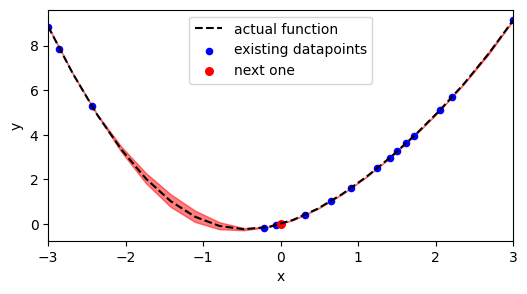

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 26 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [0.]
next x: [0.]


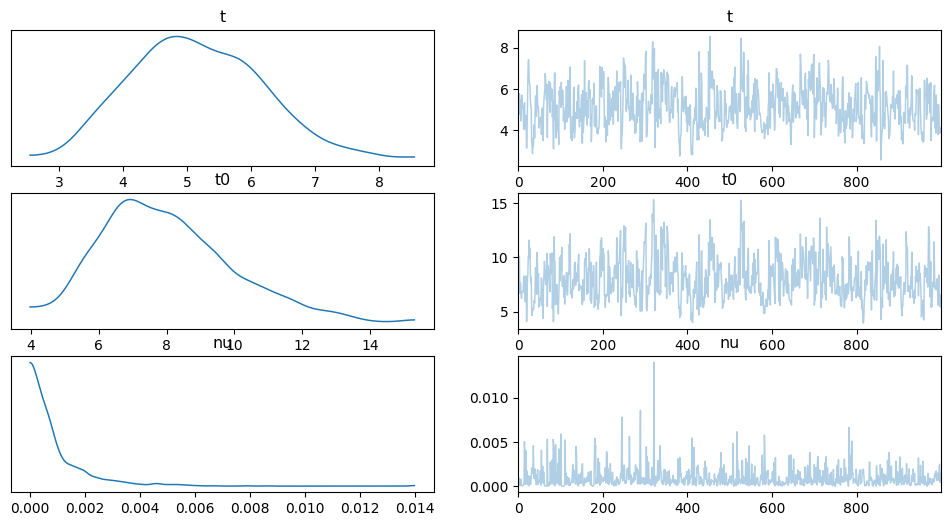

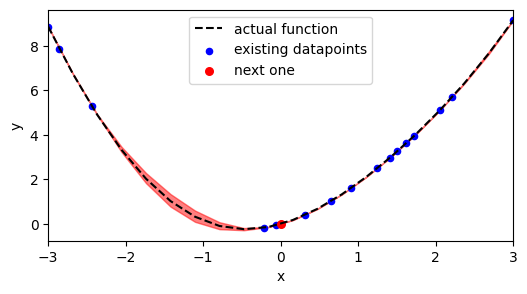

grad: [0.]
next x: [0.]


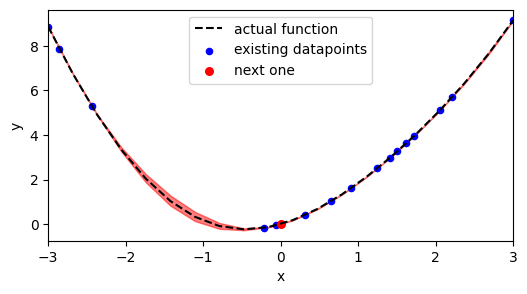

grad: [0.]
next x: [0.]


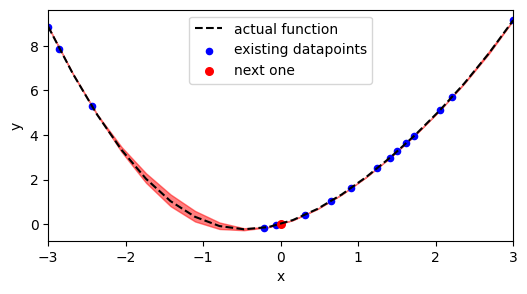

grad: [0.]
next x: [0.]


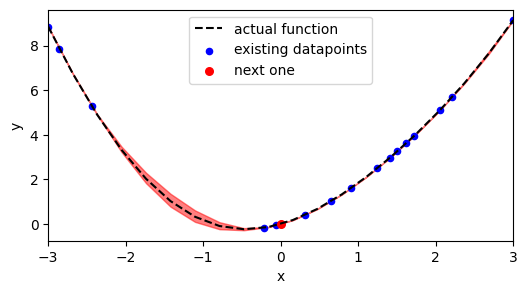

best x:  [-0.22073029]


In [18]:
maximum_iteration = 5
#Initialize
PI_MCMC= Bayesian_Optimization(objective=objective, x_range = x_range, init_points=init_points, initialplot=True)
#Optimize
PI_MCMC_best,PI_MCMC_x, PI_MCMC_y = PI_MCMC.Iteration(mode = "MCMC",acquisition = "PI", max_iter = maximum_iteration)
print("best x: ",PI_MCMC_best)

MCMC, Acquisition Function: Expectation Improvement

[[-3.        ]
 [-2.62285446]
 [-2.03024578]
 [-1.96895126]
 [-1.57538181]
 [-0.21194509]
 [-0.09683198]
 [ 0.56705459]
 [ 0.8725853 ]
 [ 1.07211263]
 [ 1.25830869]
 [ 1.47089056]
 [ 2.42216541]
 [ 2.85784797]
 [ 3.        ]]


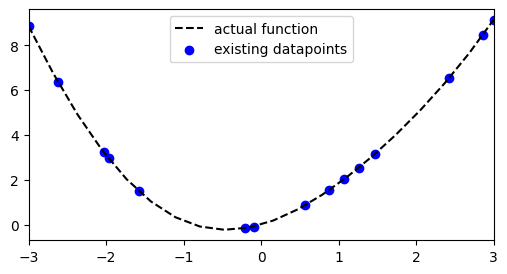

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [1.80987588e-06]
next x: [-0.27265381]


<Figure size 640x480 with 0 Axes>

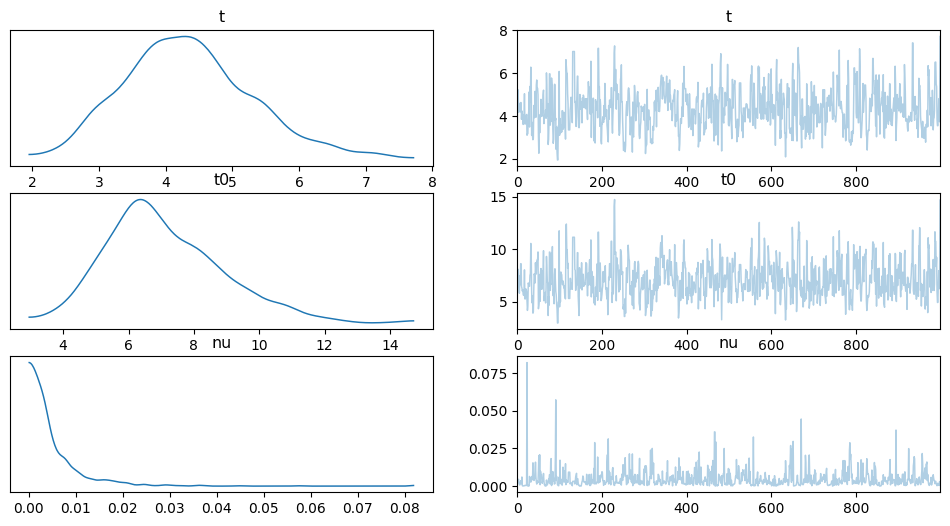

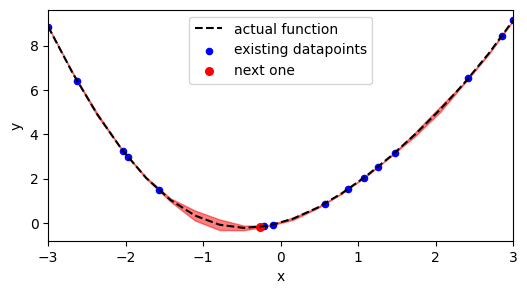

grad: [-1.41430921e-06]
next x: [-0.3035112]


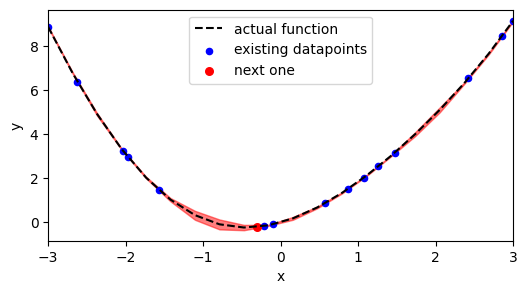

grad: [-9.98869716e-06]
next x: [-0.30346568]


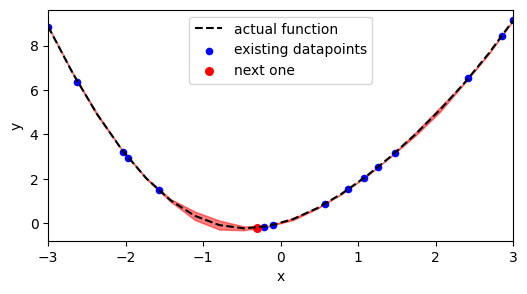

grad: [-8.35362355e-06]
next x: [-0.33076612]


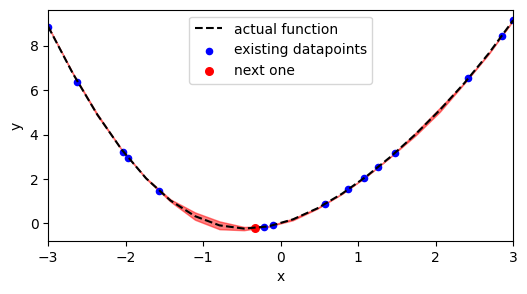

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [-5.88886097e-06]
next x: [-0.40971977]


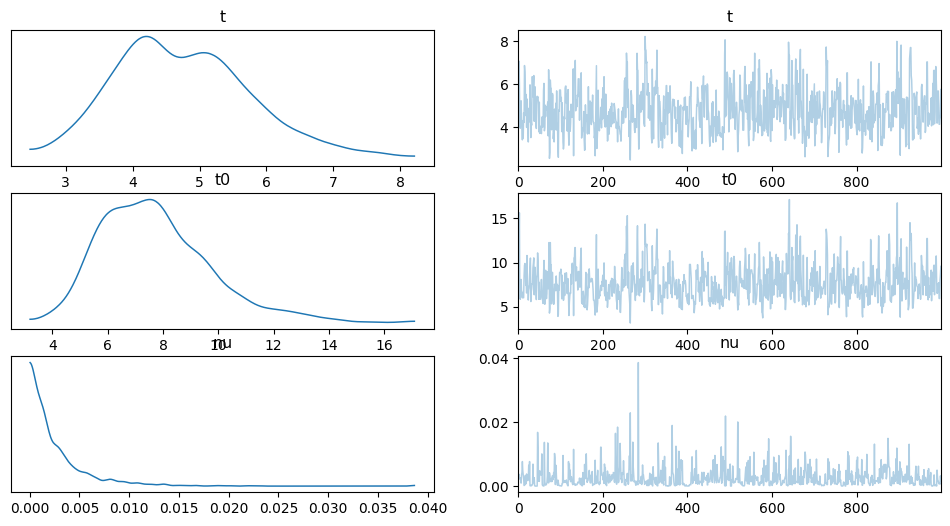

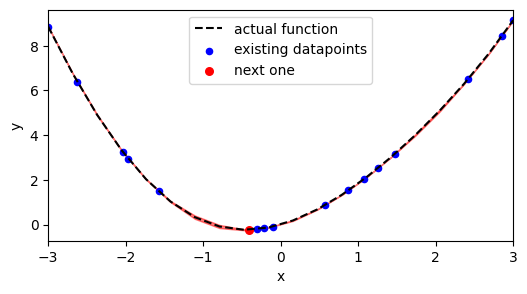

grad: [2.49742176e-06]
next x: [-0.36453483]


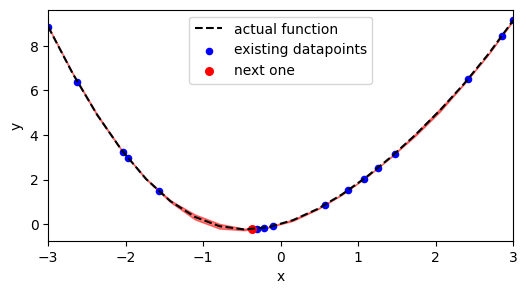

grad: [-8.7491645e-06]
next x: [-0.39799589]


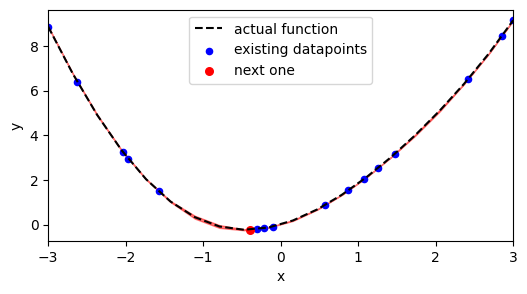

grad: [-8.19544364e-06]
next x: [-0.3936035]


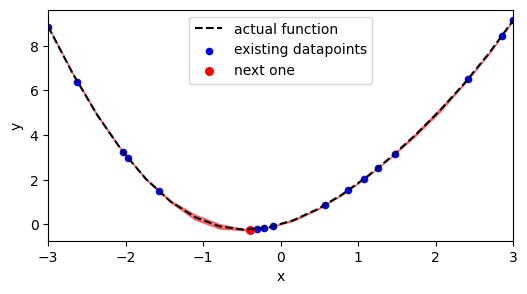

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [-5.33890457e-06]
next x: [-0.42761681]


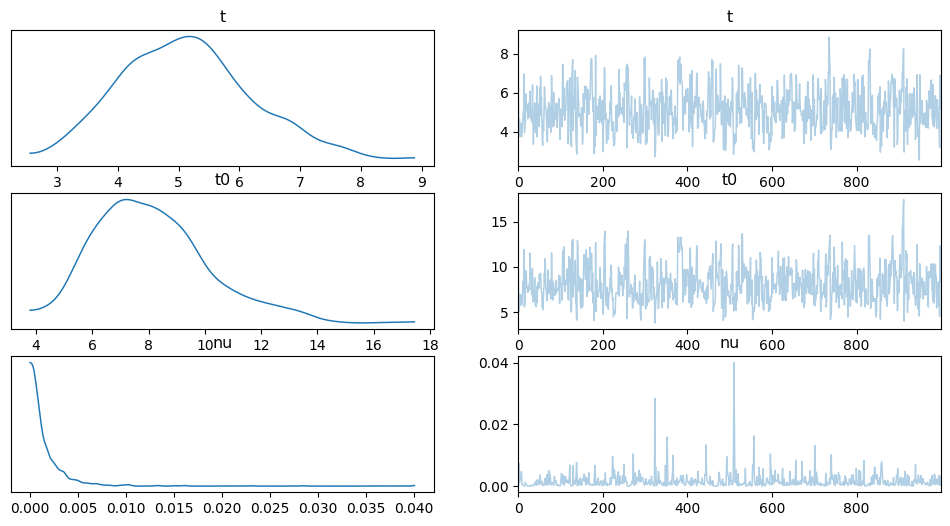

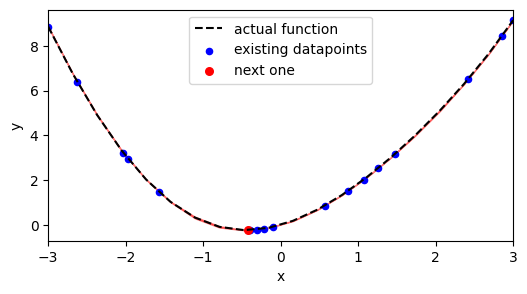

grad: [4.23009718e-05]
next x: [-0.41921898]


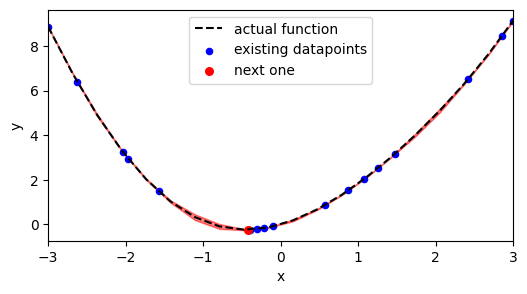

grad: [8.58997796e-07]
next x: [-0.4228494]


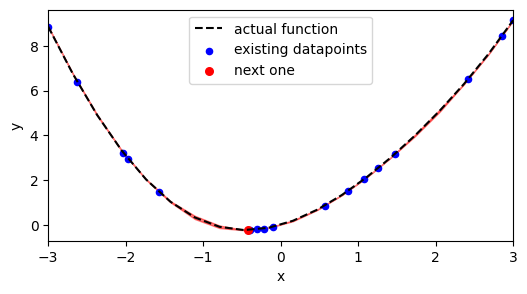

grad: [1.79386616e-05]
next x: [-0.42688906]


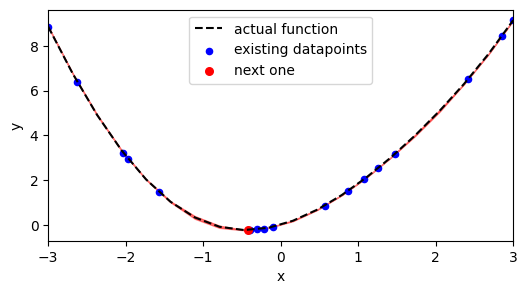

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [0.00021616]
next x: [-0.43494649]


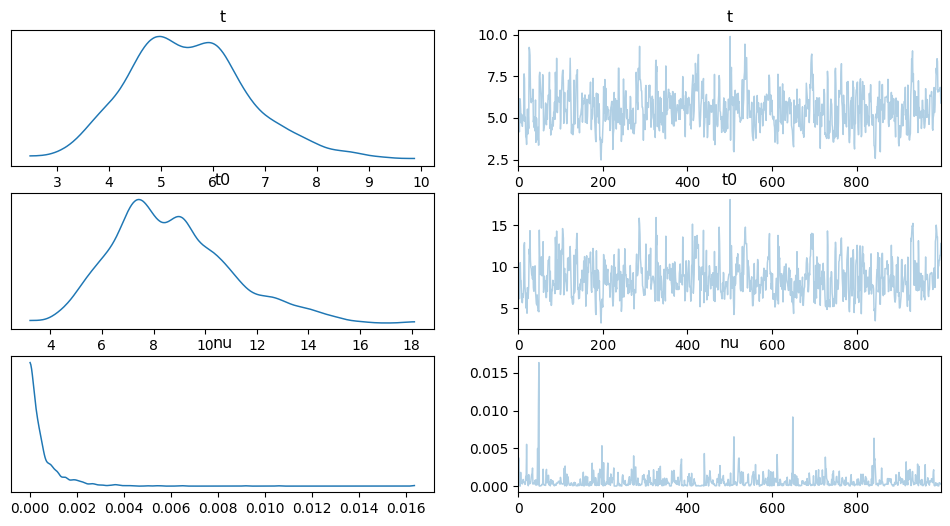

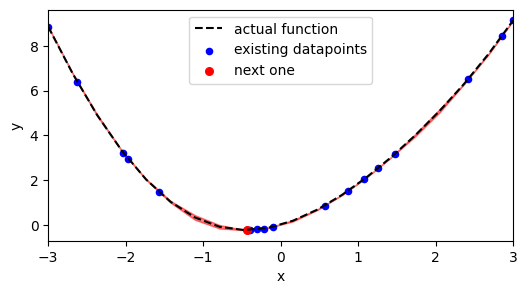

grad: [-5.38509667e-06]
next x: [-0.43837232]


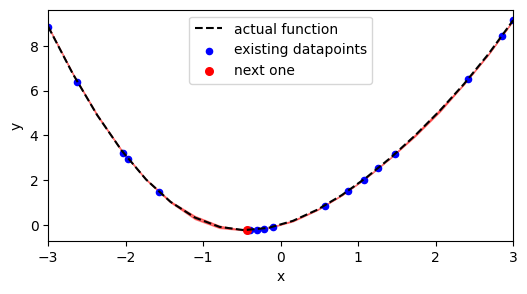

grad: [7.38156823e-06]
next x: [-0.43919744]


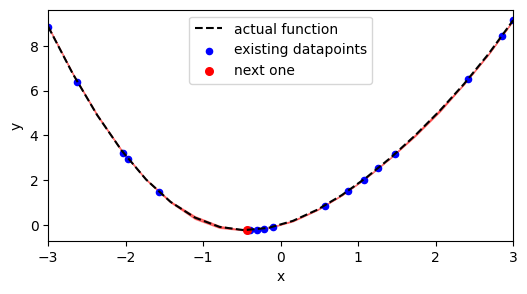

grad: [0.00035582]
next x: [-0.44058735]


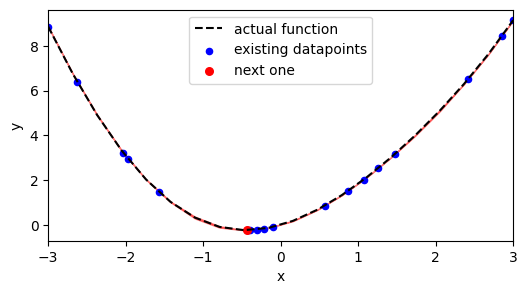

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [0.00027608]
next x: [-0.44306613]


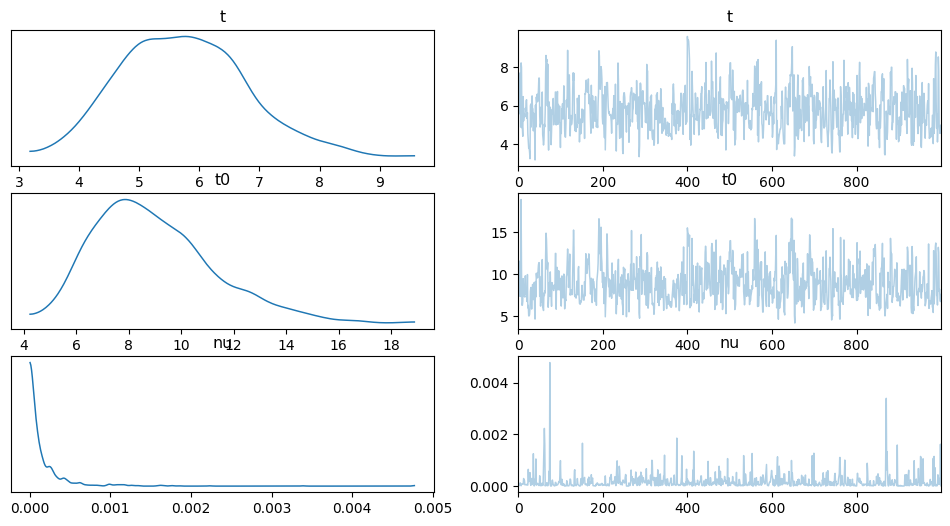

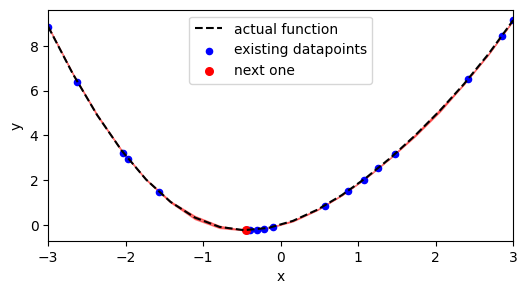

grad: [0.0013074]
next x: [-0.44417652]


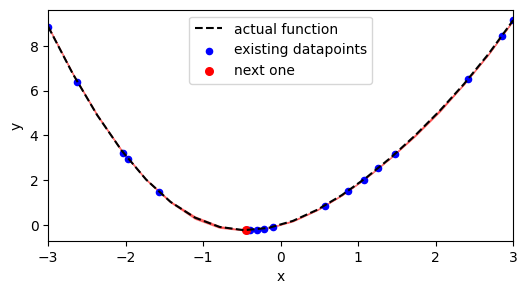

grad: [-0.00029162]
next x: [-0.44460521]


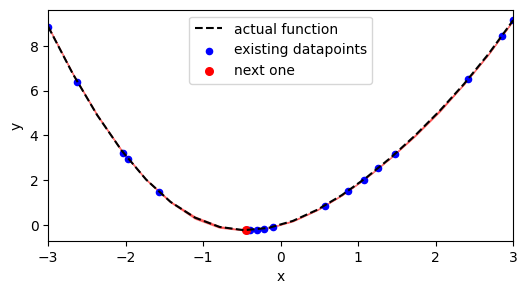

grad: [0.00130145]
next x: [-0.44458544]


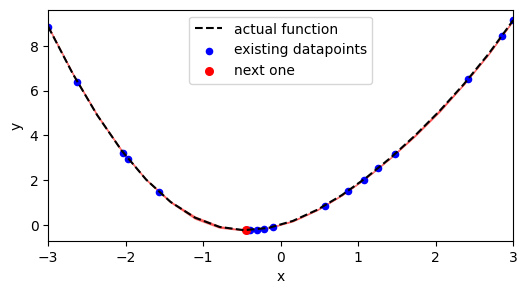

best x:  [-0.44410832]


In [24]:
maximum_iteration = 5
#Initialize
EI_MCMC= Bayesian_Optimization(objective=objective, x_range = x_range, init_points=init_points, initialplot=True)
#Optimize
EI_MCMC_best,EI_MCMC_x, EI_MCMC_y = EI_MCMC.Iteration(mode = "MCMC",acquisition = "EI", max_iter = maximum_iteration)
print("best x: ",EI_MCMC_best)

MCMC, Acquisition Function: Lower Confidence Bound

[[-3.        ]
 [-2.942152  ]
 [-2.25336457]
 [-1.67523057]
 [-1.52676169]
 [-1.46188321]
 [-1.17057733]
 [ 0.80821375]
 [ 0.90839732]
 [ 1.22141617]
 [ 1.40777776]
 [ 1.58840451]
 [ 2.36482065]
 [ 2.98169361]
 [ 3.        ]]


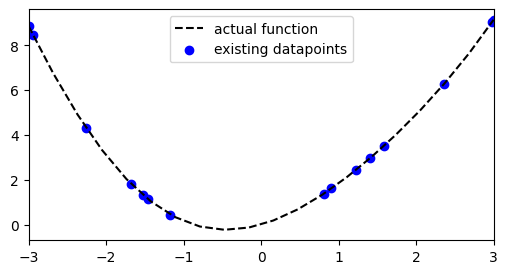

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [0.00102058]
next x: [-0.37863246]


<Figure size 640x480 with 0 Axes>

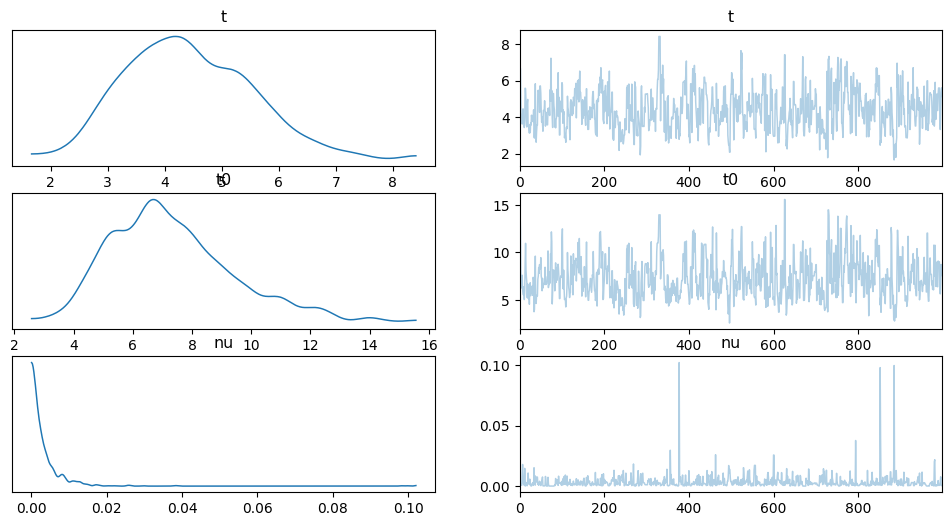

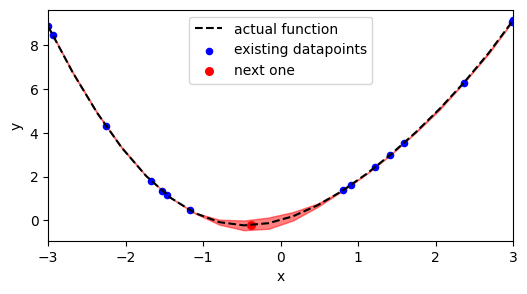

grad: [-0.00012136]
next x: [-0.36984883]


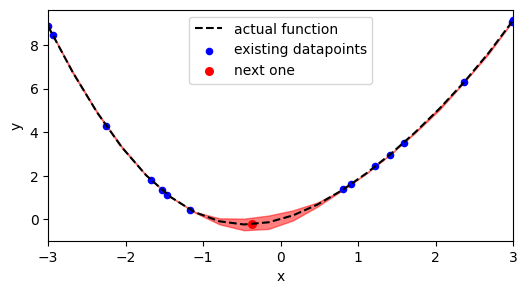

grad: [-9.54791802e-07]
next x: [-0.37891571]


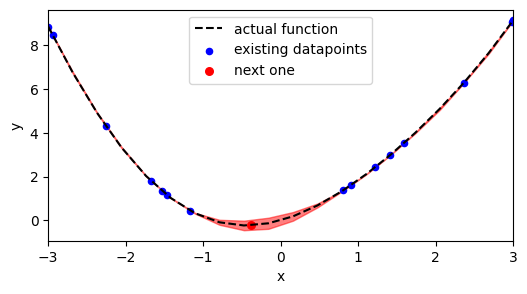

grad: [1.45439216e-05]
next x: [-0.34387745]


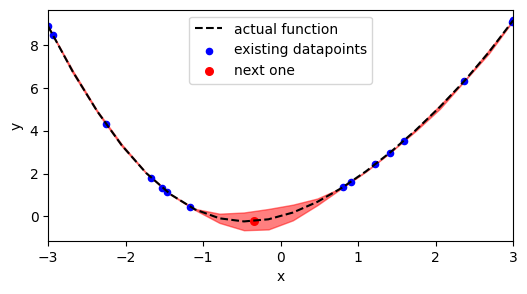

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, t0, t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [0.00039486]
next x: [-0.52682216]


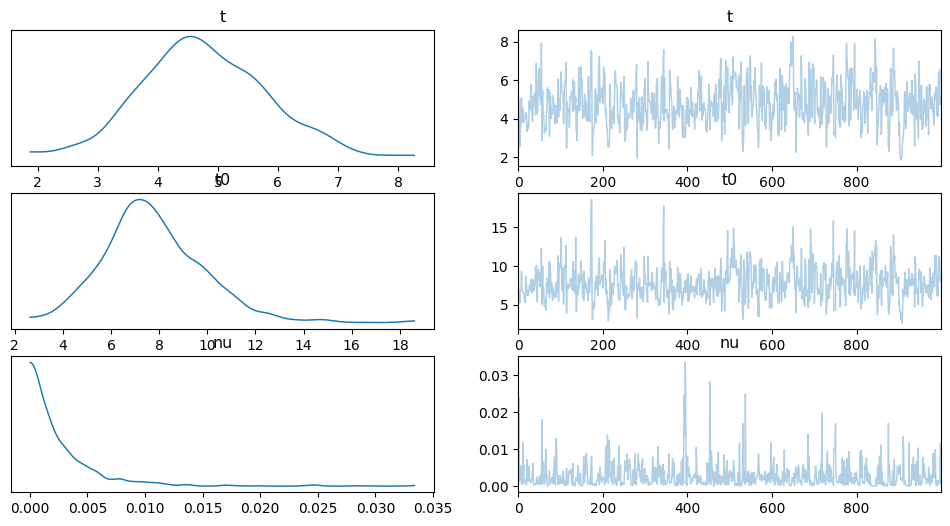

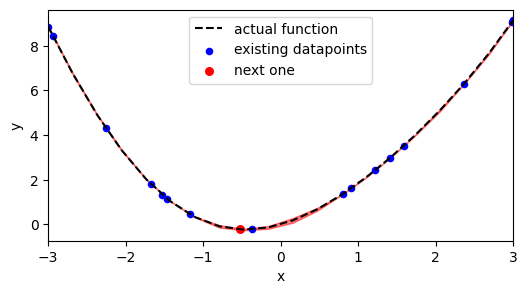

grad: [4.6684878e-06]
next x: [-0.51919791]


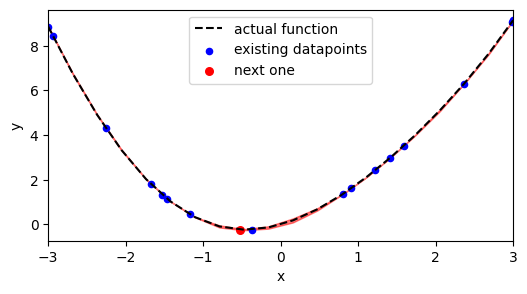

grad: [0.0005155]
next x: [-0.52368148]


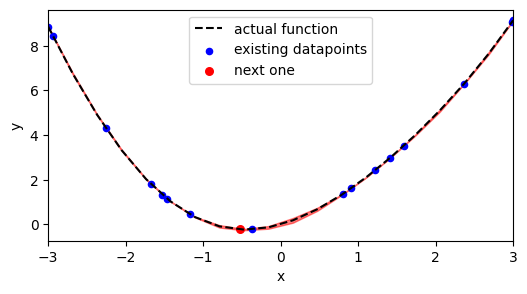

grad: [3.37729842e-05]
next x: [-0.56686452]


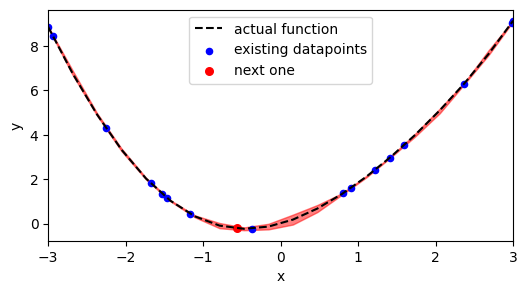

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [-0.00017342]
next x: [-0.45030315]


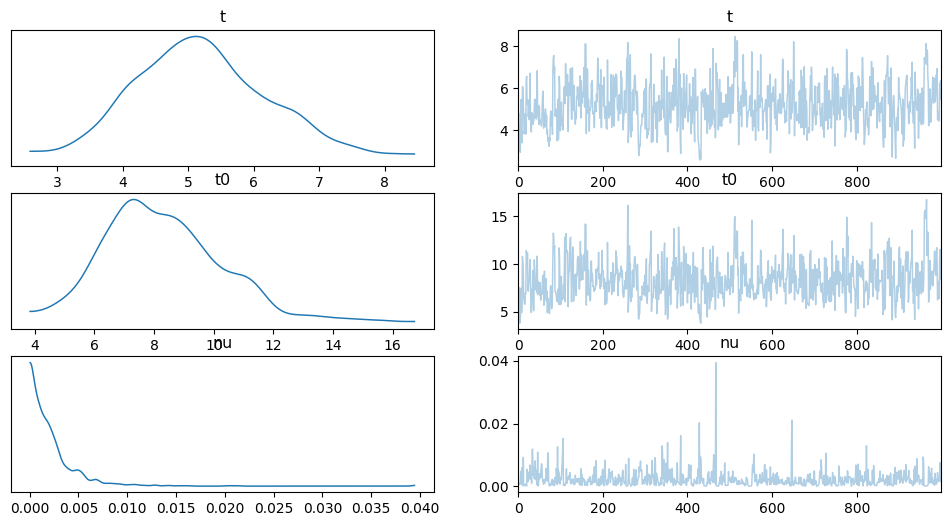

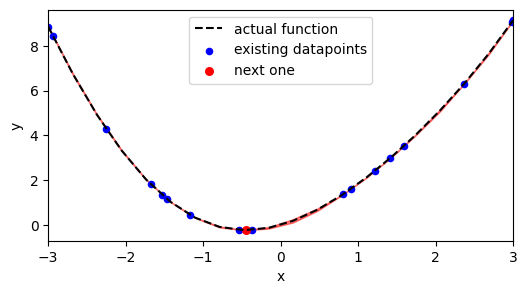

grad: [-3.24379412e-05]
next x: [-0.45011825]


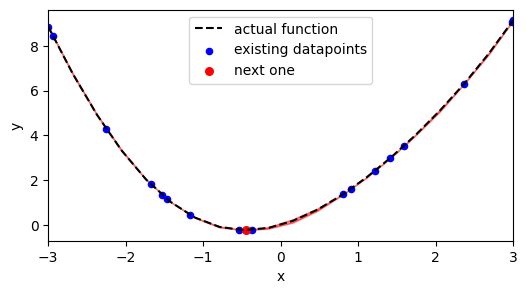

grad: [0.00019304]
next x: [-0.4511408]


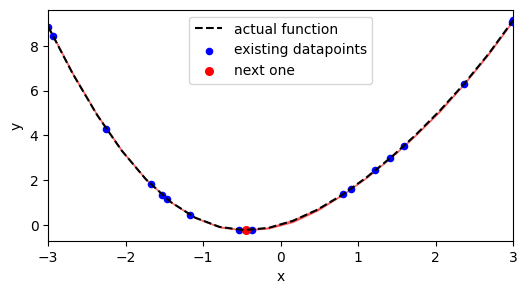

grad: [-0.00041824]
next x: [-0.45026777]


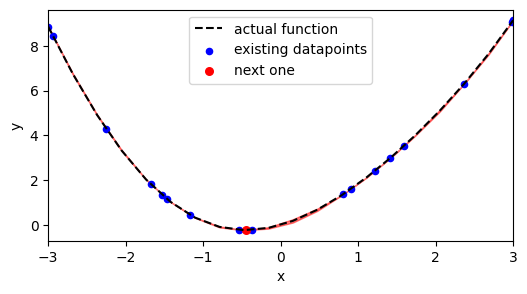

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [0.00078515]
next x: [-0.4496658]


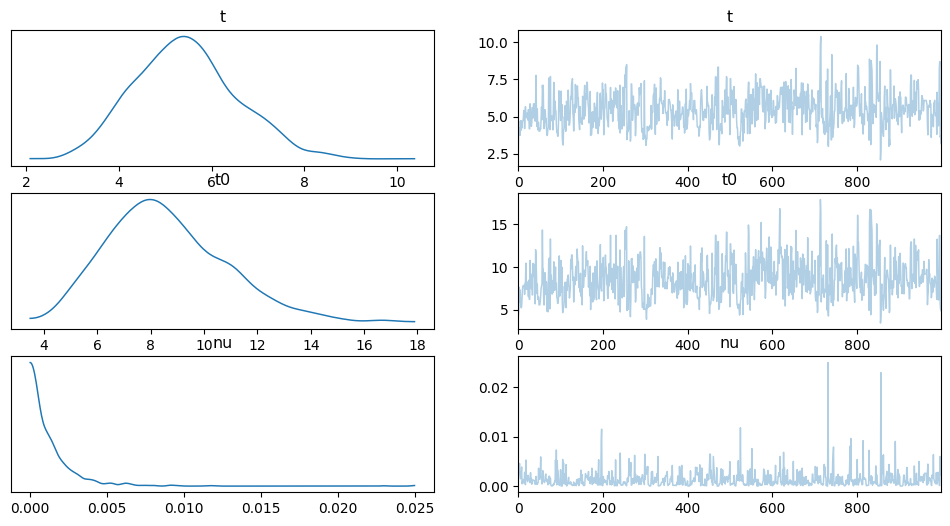

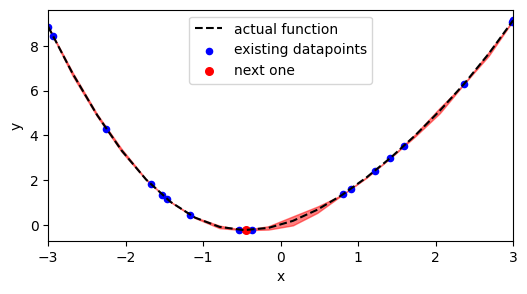

grad: [0.00121129]
next x: [-0.44916992]


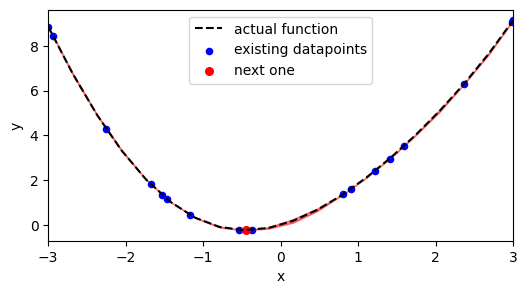

grad: [7.47624185e-05]
next x: [-0.45121381]


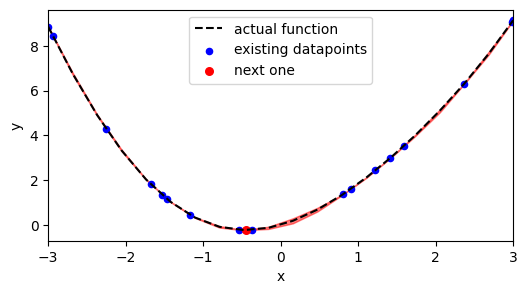

grad: [-0.00191922]
next x: [-0.45004339]


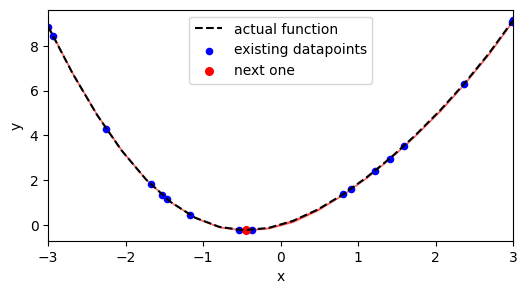

c:\Users\madel\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, t0, t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\madel\AppData\Local\Temp\ipykernel_35604\2823577951.py:87: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


grad: [-0.00045579]
next x: [-0.45091781]


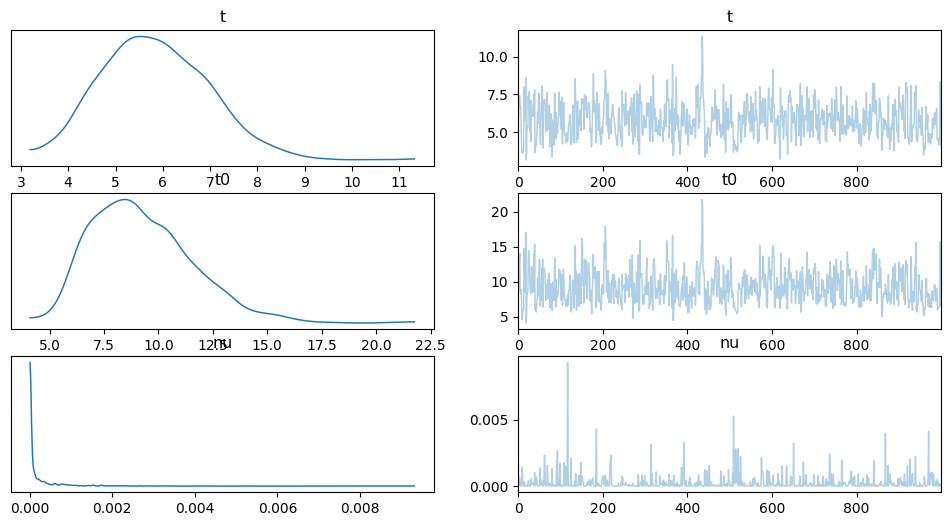

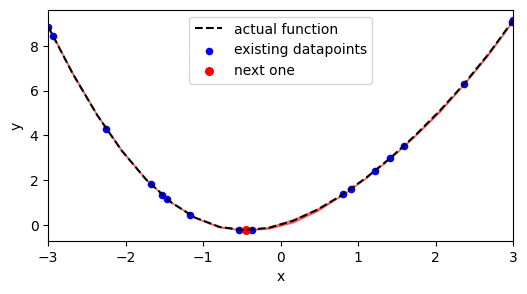

grad: [-0.00105902]
next x: [-0.4536272]


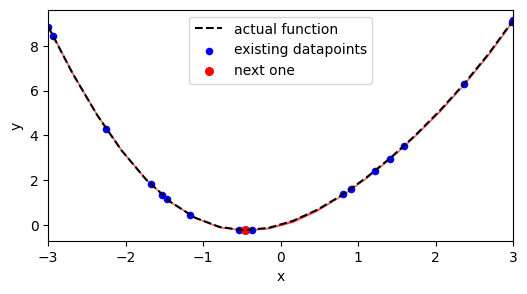

grad: [0.00176232]
next x: [-0.45008091]


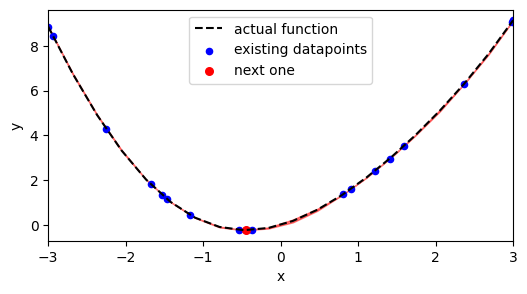

grad: [0.01577211]
next x: [-0.45052772]


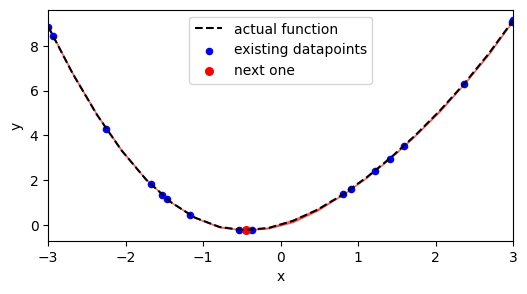

best x:  [-0.45002323]


In [26]:
maximum_iteration = 5
#Initialize
LCB_MCMC= Bayesian_Optimization(objective=objective, x_range = x_range, init_points=init_points, initialplot=True)
#Optimize
LCB_MCMC_best,LCB_MCMC_x, LCB_MCMC_y = LCB_MCMC.Iteration(mode = "MCMC",acquisition = "LCB", max_iter = maximum_iteration)
print("best x: ",LCB_MCMC_best)

Using Newton Raphson Method to find approximate $x_{best}$ value for comparison

In [12]:
import math

def f(x):
    return math.cos(x) + 2*x

def f_prime(x):
    return -math.sin(x) + 2

def newton_raphson(guess, tolerance):
    x_n = guess
    while True:
        fxn = f(x_n)
        if abs(fxn) < tolerance:
            return x_n
        fprime_xn = f_prime(x_n)
        if fprime_xn == 0:
            raise ValueError("Newton-Raphson method failed.")
        x_n1 = x_n - fxn / fprime_xn
        if abs(x_n1 - x_n) < tolerance:
            return x_n1
        x_n = x_n1

# Example usage with initial guess of x=1 and tolerance of 1e-6
result = newton_raphson(guess=1, tolerance=1e-6)
print(f"The solution is x = {result}")

The solution is x = -0.45018366192290454
